# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC2997/NGC2997_R.fits')
data = hdu['PRIMARY'].data

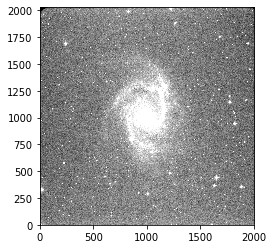

In [4]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=17, vmax=21)

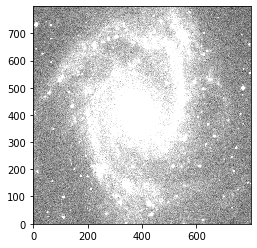

In [5]:
#cut
from astropy.nddata import Cutout2D
position = (1010, 1003)
size=(800,800)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=17, vmax=21)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [7]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

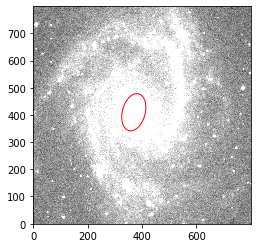

In [18]:
# how does it look?
geometry = EllipseGeometry (x0=370, y0=410, sma=70, eps=0.6,pa=75*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=17, vmax=21)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [19]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [20]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,113.5355773766585,0.0,0.0,0.0,0.0,0.0,0.0,None,None,385.428690684839,0.0,408.06311797466356,0.0,1,0,0,0
0.5420896268773124,113.24462376965553,0.04274265876843173,0.7654790384036235,0.012589055484692663,176.53521793341056,0.815098596800291,-1.5815533548766785,1.518355753767097,0.9600408036094936,385.428690684839,0.014552447116291944,408.06311797466356,0.003734656176427937,13,0,14,0
0.5962985895650437,112.65994686575824,0.061594942347820814,0.49410404780614503,0.012658292749655006,176.53521793341056,1.0408948326568213,-4.426470856126032,2.10607718431997,0.47579149457298603,385.4509259737773,0.00746398243269288,408.1360821605535,0.00403894532930797,13,0,19,0
0.6559284485215481,111.7550290110715,0.12901760650077104,0.12368574091509549,0.025402422641604708,165.7960231084986,6.696906602782371,-7.309675852336455,3.4234546624836186,0.4683456191001069,385.44350450247794,0.009484762362593246,408.22593566491935,0.008916662882129512,13,0,10,0
0.721521293373703,111.47838890763965,0.15188186967288803,0.11451996837152009,0.021862246447442134,125.18208680543339,6.195078197692339,-9.184990068706279,3.1755299741966545,0.3457303655684772,385.43579825793125,0.008579151355821895,408.2750310528798,0.00875389184178154,13,0,10,0
0.7936734227110733,110.78265663557258,0.16360333189808732,0.10101415110995796,0.01753223932663053,106.44157634526671,5.59179818763417,-11.391832704565111,3.426392445877707,0.3007762258047057,385.4356688346124,0.007436367538596284,408.2664356442111,0.00772574683566263,13,0,10,0
0.8730407649821808,109.96805768580043,0.17265957833660514,0.1125432250541577,0.016506861308455686,102.29307870236858,4.750197689818278,-11.457775787290704,3.498514352169071,0.30533974631007565,385.42221657662526,0.007701100060786333,408.23649560486933,0.008112410910576335,13,0,10,0
0.9603448414803989,109.0832535234923,0.2205129461634854,0.11902328394068844,0.01885241997071996,97.94340610043581,5.150789190192708,-11.56875870938166,4.001601954967017,0.3458972613649489,385.40862836493574,0.009656247342403224,408.20772891993266,0.010284561398926499,13,0,10,0


Text(0, 0.5, 'Ellipticity')

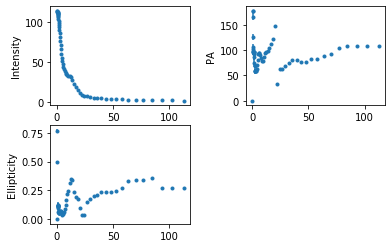

In [21]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [22]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5, 1.0, 'Residual')

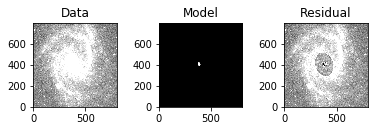

In [23]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', vmin=17, vmax=21)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', vmin=17, vmax=21)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', vmin=17, vmax=21)
ax3.set_title('Residual')